# Natural Language Classification

In [1]:
import pandas as pd
import numpy as np
import random
import re
import json

import os.path
from os import path
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
MODEL_CONFIG = {
                  "model_name": "my_nlc_model.h5",
                  "model_weights": "my_nlc_model.hdf5",
                  "log_dir": "tensorboard_logs",
                  "max_features": 500,
                  "maxlen": 50,
                  "epochs": 200,
                  "batch_size": 32,
                  "activation": "softmax",
                  "loss": "binary_crossentropy",
                  "optimizer": "adam",
                  "metrics": ["accuracy"],
                  "patience": 20
                }

CONFIG = {
            "DATA_DIR": 'data/',
            "RESULT_DIR": 'results/',
            "DATA_FILE_PATH": 'data/InsuranceAgentIntents.csv',
            "MODEL_PATH": 'results/model/'+MODEL_CONFIG['model_name']
         }

print(CONFIG)

{'DATA_DIR': 'data/', 'RESULT_DIR': 'results/', 'DATA_FILE_PATH': 'data/InsuranceAgentIntents.csv', 'MODEL_PATH': 'results/model/my_nlc_model.h5'}


In [3]:
# LOAD DATA
df = pd.read_csv(CONFIG['DATA_FILE_PATH'], sep=',')
df.head()

,utterances,intent
0,tes,AFFIRM
1,Yes that's right,AFFIRM
2,Yes,AFFIRM
3,ye,AFFIRM
4,sure,AFFIRM


## Check the Quality of data for training

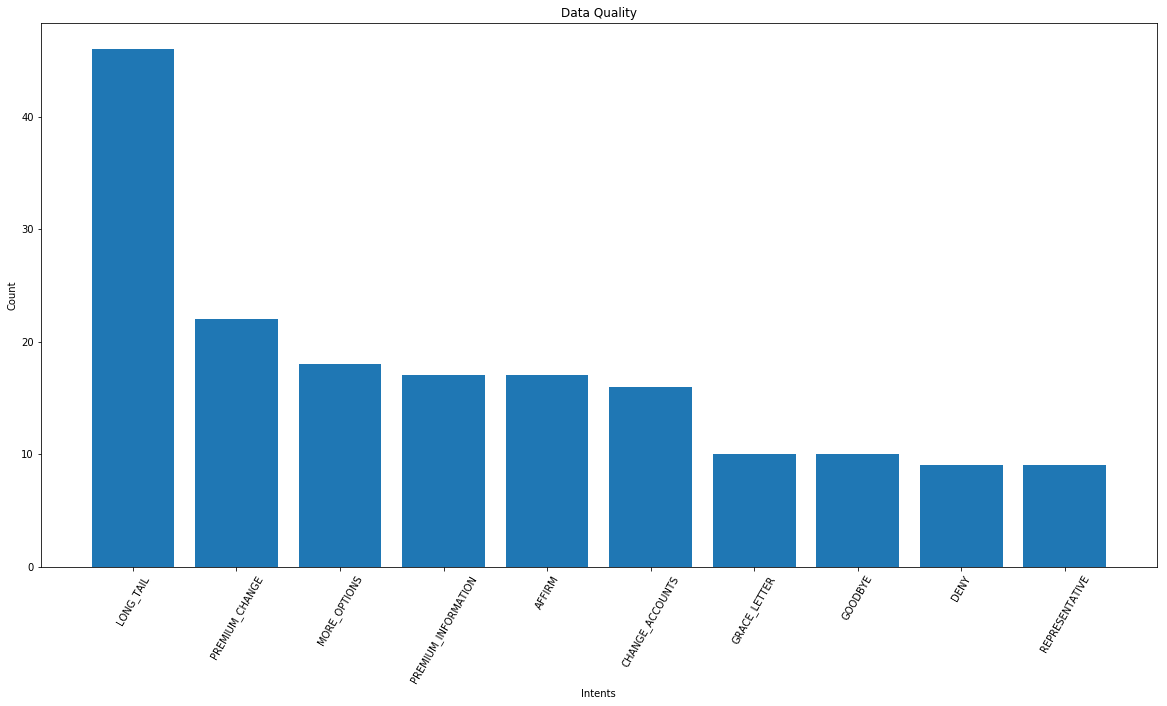

In [4]:
# df_quality_counts.plot()
# print(df_quality_counts.keys())
# print(df_quality_counts.values)
# df_quality_counts = df['intent'].value_counts().to_frame()
# df_quality_counts.rename(columns={'intent': 'value_counts'}, inplace=True)
# df_quality_counts.index.name = 'intent'
# print(df_quality_counts)
# print(df_quality_counts["value_counts"].unique())

# df_quality_counts = df['intent'].value_counts()
# df_quality_counts
df_quality_counts = df['intent'].value_counts().head(10)
plt.figure(figsize=(20,10))
plt.title("Data Quality")
# plt.ylim()
plt.xlabel("Intents")
plt.xticks(rotation=60)
plt.ylabel("Count")
plt.bar(df_quality_counts.keys(), df_quality_counts.values)
plt.show()  

In [5]:
X_train = df['utterances']
Y_train = df['intent']
X_test = pd.Series(["turn on the living room tubelight", "how is the weather in Bangalore"])
Y_test = pd.Series(["turn_on", "weather"])

## Using Scikit Learn for Classification

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(198, 253)
(198, 253)


In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)
print("\n\nPrediction using MultinomialNB: >> ", clf.predict(count_vect.transform(X_test)))



Prediction using MultinomialNB: >>  ['appliance_action' 'weather']


## Using Tensorflow and Keras for Classification

In [8]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
# from tf.keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D
# from tf.keras.layers.core import Dropout
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
class DataSet(object):
    def __init__(self, utterances, intents):
        self._utterances = utterances
        self._intents = intents

    @property
    def utterances(self):
        return self._utterances

    @property
    def intents(self):
        return self._intents

In [10]:
!mkdir results
!mkdir results/model

In [11]:
def get_tokenizer():
        tokenizer = Tokenizer(num_words=MODEL_CONFIG["max_features"], split=' ')
        tokenizer.fit_on_texts(df["utterances"].values)
        return tokenizer

In [12]:
def get_training_data():
        documents = []
        X = get_tokenizer().texts_to_sequences(df["utterances"].values)
        X = pad_sequences(X, maxlen=MODEL_CONFIG["maxlen"])
        intents = df["intent"].unique()
        intents = sorted(list(set(intents)))
        output_empty = [0] * len(intents)
        Y = []
        for i in range( 0, len(X)):
            output_row = list(output_empty)
            intent = df["intent"][i]
            output_row[intents.index(intent)] = 1
            Y.append(output_row)

        print("Length of X: >> ", len(X))
        print("Length of Y: >> ", len(Y))
        return X, Y

In [13]:
class DataSets(object):
            pass
datasets = DataSets()
def prepare_data():
        X, Y = get_training_data()
        print("Training Data Length: ", len(X))
        print("Training Data Target Length: ", len(Y))
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
        datasets.train = DataSet(X_train, Y_train)
        datasets.test = DataSet(X_test, Y_test)

In [14]:
def create_model():
        K.clear_session()
        tf.reset_default_graph()
        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
          sess.run(init_g)
          sess.run(init_l)
          # Create the network definition based on Gated Recurrent Unit (Cho et al. 2014).
          embedding_vector_length = 32

          model = Sequential()
          model.add(Embedding(MODEL_CONFIG["max_features"], embedding_vector_length, input_length=MODEL_CONFIG["maxlen"]))
          model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
          model.add(MaxPooling1D(pool_size=2))
          model.add(LSTM(100))
          model.add(Dense(len(datasets.train.intents[0]), activation=MODEL_CONFIG["activation"]))
          model.compile(loss=MODEL_CONFIG["loss"], optimizer=MODEL_CONFIG["optimizer"], metrics=MODEL_CONFIG["metrics"])
          print(model.summary())

          tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=CONFIG["RESULT_DIR"]+MODEL_CONFIG["log_dir"], write_graph=True)

          monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=MODEL_CONFIG["patience"], verbose=0, mode='auto')
          # checkpointer = ModelCheckpoint(filepath=self.CONFIG["MODEL_WEIGHTS_PATH"], verbose=0, save_best_only=True) # Save best model
          model.fit(np.asarray(datasets.train.utterances), np.asarray(datasets.train.intents), epochs=MODEL_CONFIG["epochs"], batch_size=MODEL_CONFIG["batch_size"],  verbose=1, validation_split=0.02, callbacks=[tbCallBack, monitor])
          # model.load_weights(self.CONFIG["MODEL_WEIGHTS_PATH"]) # load weights from best model
          scores = model.evaluate(np.asarray(datasets.test.utterances), np.asarray(datasets.test.intents))
          print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
          model.save(CONFIG["MODEL_PATH"])
          print("<<<<<<<< ML MODEL CREATED AND SAVED LOCALLY AT: ", CONFIG["MODEL_PATH"])
          word_index_file = os.path.join(CONFIG["DATA_DIR"], 'word_index.json')
          with open(word_index_file, 'w') as outfile:
               json.dump(get_tokenizer().word_index, outfile)                
          print("word_index.json file uploaded successfully....")

In [15]:
prepare_data()
create_model()

Length of X: >>  198
Length of Y: >>  198
Training Data Length:  198
Training Data Target Length:  198
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 73,516
Trai

174/174 [==============================] - 0s 1ms/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.2601 - val_acc: 0.9167
Epoch 50/200
174/174 [==============================] - 0s 1ms/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.2526 - val_acc: 0.9167
Epoch 51/200
174/174 [==============================] - 0s 2ms/step - loss: 0.0058 - acc: 0.9976 - val_loss: 0.2451 - val_acc: 0.9167
Epoch 52/200
20/20 [==============================] - 0s 313us/step

acc: 95.83%
<<<<<<<< ML MODEL CREATED AND SAVED LOCALLY AT:  results/model/my_nlc_model.h5
word_index.json file uploaded successfully....


In [16]:
def convert_to_predict(texts):
        preprocessed_records = []
        for text in texts:
            cleanString = re.sub(r"[!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~]", "", text)
            splitted_text = cleanString.split()[:MODEL_CONFIG["maxlen"]]
            hashed_tokens = []
            for token in splitted_text:
                index = get_tokenizer().word_index.get(token, 0)
                # index = scoring_params["word_index"].get(token, 0)
                if index < 501 and index > 0:
                    hashed_tokens.append(index)

            hashed_tokens_size = len(hashed_tokens)
            padded_tokens = [0]*(MODEL_CONFIG["maxlen"] - hashed_tokens_size) + hashed_tokens
            preprocessed_records.append(padded_tokens)
        return preprocessed_records

In [23]:
def get_intents():
        intents = df["intent"].unique()
        intents = sorted(list(set(intents)))
        return intents

In [35]:
def get_results(sentences):
    print(sentences)
    ERROR_THRESHOLD = 0.15
    scoring_data = None
    to_predict_list = []
    toPredict = convert_to_predict(sentences)
    model = load_model(CONFIG["MODEL_PATH"])
    predictions = model.predict(np.asarray(toPredict))
    intents = get_intents()
    return_list = []
    for result in predictions:
        result = [[i,r] for i,r in enumerate(result) if r>ERROR_THRESHOLD]
        result.sort(key=lambda x: x[1], reverse=True)
        classifyResp = []
        for r in result:
            classifyResp.append((intents[r[0]], r[1]))
        return_list.append(classifyResp)
    return return_list
   

In [37]:
query = "Turn off the kitchen fan ## how is the weather outside ## are you a bot ?"
print(get_results(query.split("##")))

['Turn off the kitchen fan ', ' how is the weather outside ', ' are you a bot ?']
[[('appliance_action', 0.90204954)], [('weather', 0.9920359)], [('General_Human_or_Bot', 0.8770767)]]
